In [2]:
import numpy as np
import pandas as pd
from math import log

g = lambda RD,q : 1 / np.sqrt(1 + 3 * q ** 2 * RD ** 2 / np.pi ** 2)

In [84]:
class Glicko2:
    
    def __init__(self,n_students,n_questions,c=63.2,q=log(10)/400,true_level = [None] , true_dificulty = [None] , \
                P_true = np.array([None])):
        

        self.c = c
        self.n_students = n_students
        self.n_questions = n_questions
        self.r_students = 1500 * np.ones(n_students)
        
  
        self.r_questions = 1500 * np.ones(n_questions)
        self.RD_students = 350 * np.ones(n_students)
        self.RD_questions = 350 * np.ones(n_questions)
        self.q = q
           
        if None in P_true:    
            
           if None in true_dificulty:
              self.true_dificulty = np.random.rand(n_questions)
           else:
              self.true_dificulty = true_dificulty
        
           if None in true_level:
              self.true_level = np.random.rand(n_students)
           else:    
              self.true_level = true_level
           
           self.P_true = (1/(1+np.exp(-(self.true_level.reshape((-1,1))-self.true_dificulty.reshape((1,-1))))))

        else:
            
           self.P_true = P_true
        
        
        self.all_questions_answered = {i:[] for i in range(self.n_students)}

        
    def answer_question(self,students="all", periods = 0):
        
        if students == "all":
          
           students = list(range(self.n_students))
            
        self.RD_students = np.min([np.sqrt(self.RD_students.reshape((1,-1))**2\
                        +periods * self.c**2),350 * np.ones((1,self.n_students))],axis = 0)   
        self.P_est = 1/(1+10**(-g(np.sqrt(self.RD_students.reshape((-1,1))**2 + \
                                     self.RD_questions.reshape((1,-1))**2),self.q)\
                               *(self.r_students.reshape((-1,1))\
                                                                   -self.r_questions.reshape((1,-1)))/400))
        
        noise = np.random.randn(self.P_est.shape[0],self.P_est.shape[1])
        self.questions_answered = {i:np.abs(self.P_est -0.5 + 0.05 * noise)\
        .argmin(axis = 1)[i] for i in students}
        
        
        s = (np.random.rand(self.n_students,1) < \
np.array([self.P_true[i,self.questions_answered[i]] for i in range(self.n_students)]).reshape((-1,1))).astype(int)
        
        for i in students:
            j = self.questions_answered[i]
            E_student = 1 / (1 + 10 ** (-g(self.RD_questions[j],self.q)*(self.r_students[i] * self.r_questions[j])/400))
            d_student = (self.q ** 2 * g(self.RD_questions[i],self.q) ** 2 * E_student * (1- E_student))**(-1)
            self.r_students[i] += (self.q / (1 / self.RD_students[i]**2 + 1 / d_student ** 2)) * (s[i] - E_student)
            self.r_students[0] = 1500
            
            E_question = 1 / (1 + 10 ** (-g(self.RD_students[i],self.q)*(self.r_students[i] - self.r_questions[j])/400))
            d_question = (self.q ** 2 * g(self.RD_students[i],self.q) ** 2  * E_question * (1- E_question))**(-1)
            self.r_questions[j] += (self.q / (1 / self.RD_questions[j]**2 + 1 / d_question ** 2)) * (1-s[i] - E_question)
            
            self.all_questions_answered[i].append((j,int(s[i])))
            self.RD_students[i] = np.sqrt((1/d_student**2 + 1 / self.RD_students[i]**2)**(-1))
            self.RD_questions[j] = np.sqrt((1/d_question**2 + 1 / self.RD_questions[j]**2)**(-1))
        
            
            
            
        
        

In [85]:
from Knowledge_learning_space_module import knowledge_learning_space

In [86]:
Q = ['a' , 'b' , 'c' , 'd' , 'e']
K_mathcal = [[],['a'],['b'],['a','b'],['b','d'],['a','b','c'],['a','b','d'],['b','c','d'],['a','b','c','d'],Q]
K0 = ['b','d']
beta_q = {'b' : 0.3 ,'d' : 0.3}

QxR = []

for q in Q:
    for r in [0,1]:
        QxR.append((q,r))

Xi = {x : 4.0 for x in QxR}

initial_prob = []
S = 0
for K in K_mathcal[:-1]:
    p = (1 - S) * np.random.rand()
    S += p
    initial_prob.append(p)
initial_prob.append(1-S)

In [129]:
glicko = Glicko2(n_questions = 5,n_students = 1,P_true = np.array([[0,0.8,0,0.8,0]]))
knowledge_network = knowledge_learning_space(Q = Q,K_mathcal = K_mathcal,Xi = Xi,K0 = K0,beta_q = beta_q)

In [130]:
prob_items_glicko = []
prob_items_KN = []

for n in range(20):
    glicko.answer_question()
    knowledge_network.simulation()
    prob_items_glicko.append(list(glicko.P_est[0]))
    prob_items_KN.append(list(knowledge_network.prob_distribution_items.values()))

C:\Users\matthieu.marechal\AppData\Local\Temp\ipykernel_26576\2488299962.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  d_student = (self.q ** 2 * g(self.RD_questions[i],self.q) ** 2 * E_student * (1- E_student))**(-1)


In [131]:
glicko.all_questions_answered

{0: [(3, 1),
  (1, 1),
  (0, 0),
  (4, 0),
  (2, 0),
  (1, 0),
  (1, 1),
  (3, 1),
  (2, 0),
  (0, 0),
  (4, 0),
  (1, 1),
  (2, 0),
  (3, 1),
  (4, 0),
  (0, 0),
  (0, 0),
  (1, 0),
  (1, 1),
  (0, 0)]}

In [132]:
pd.DataFrame({"items respondidos":[x[0] for x in glicko.all_questions_answered[0]]}).value_counts()

items respondidos
1                    6
0                    5
2                    3
3                    3
4                    3
dtype: int64

In [133]:
columns = [f'{q}-Glicko' for q in Q] + [f'{q}-NK' for q in Q]


df = pd.DataFrame(data=np.concatenate([np.array(prob_items_glicko),np.array(prob_items_KN)],axis = 1),
            columns = columns)

In [134]:
df

,a-Glicko,b-Glicko,c-Glicko,d-Glicko,e-Glicko,a-NK,b-NK,c-NK,d-NK,e-NK
0,0.500000,0.500000,0.500000,0.500000,0.500000,0.600000,0.920000,0.520000,0.800000,1.600000e-01
1,0.500000,0.500000,0.500000,0.748366,0.500000,0.540984,0.868852,0.213115,0.721311,6.557377e-02
2,0.500000,0.748366,0.500000,0.748366,0.500000,0.227586,0.862069,0.172414,0.717241,2.758621e-02
3,0.251634,0.748366,0.500000,0.748366,0.500000,0.229759,0.956236,0.212254,0.910284,3.501094e-02
4,0.251634,0.748366,0.500000,0.748366,0.251634,0.069399,0.955056,0.191011,0.909451,1.057502e-02
5,0.251634,0.748366,0.251634,0.748366,0.251634,0.061909,0.947541,0.055738,0.894889,3.085824e-03
6,0.251634,0.655654,0.251634,0.748366,0.251634,0.062026,0.985763,0.060351,0.971473,3.349908e-03
7,0.251634,0.895586,0.251634,0.748366,0.251634,0.016263,0.985727,0.057984,0.971440,8.783366e-04
8,0.251634,0.895586,0.251634,0.943950,0.251634,0.015614,0.985078,0.015155,0.970153,2.295676e-04
9,0.251634,0.895586,0.056050,0.943950,0.251634,0.015617,0.996184,0.015499,0.992367,2.348243e-04


In [135]:
import matplotlib.pyplot as plt

In [136]:
(len(knowledge_network.Q)-1)//5+1

1

C:\Users\matthieu.marechal\AppData\Local\Temp\ipykernel_26576\2484163676.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


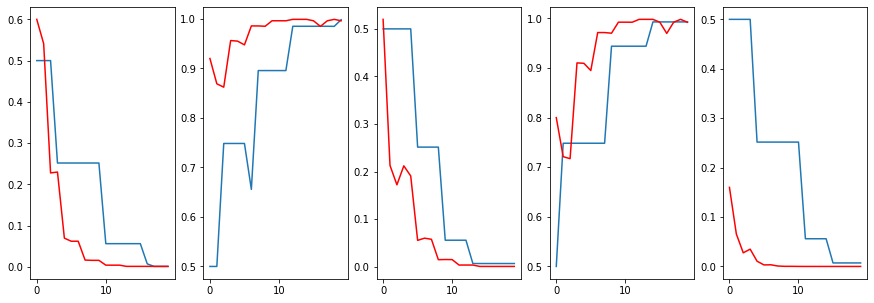

In [137]:
fig, ax = plt.subplots((len(knowledge_network.Q)-1)//5+1, 5, figsize=(15, 5))

for k,q in enumerate(knowledge_network.Q):
    
    if len(knowledge_network.Q) <= 5:
       ax[k].plot(df.index,df[f'{q}-Glicko'])
       ax[k].plot(df.index,df[f'{q}-NK'],color = "r")
    else:
       ax[(k-1)//5+1,k%5].plot(df.index,df[f'{q}-Glicko'])
       ax[(k-1)//5+1,k%5].plot(df.index,df[f'{q}-NK'],color = "r")
        
fig.show()       


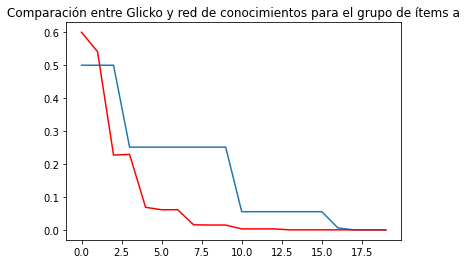

In [138]:
plt.plot(df.index,df[f'a-Glicko'])
plt.plot(df.index,df[f'a-NK'],color="red")
plt.title("Comparación entre Glicko y red de conocimientos para el grupo de ítems a")
plt.show()

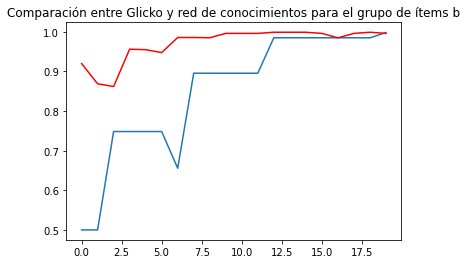

In [139]:
plt.plot(df.index,df[f'b-Glicko'])
plt.plot(df.index,df[f'b-NK'],color="red")
plt.title("Comparación entre Glicko y red de conocimientos para el grupo de ítems b")
plt.show()

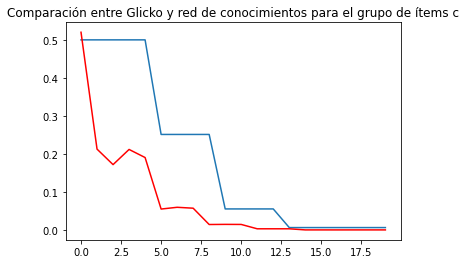

In [140]:
plt.plot(df.index,df[f'c-Glicko'])
plt.plot(df.index,df[f'c-NK'],color="red")
plt.title("Comparación entre Glicko y red de conocimientos para el grupo de ítems c")
plt.show()

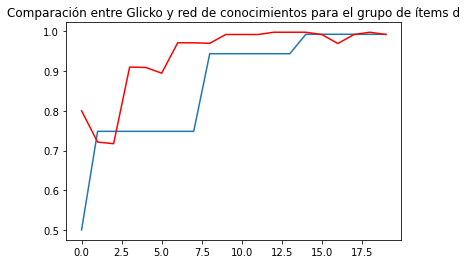

In [141]:
plt.plot(df.index,df[f'd-Glicko'])
plt.plot(df.index,df[f'd-NK'],color="red")
plt.title("Comparación entre Glicko y red de conocimientos para el grupo de ítems d")
plt.show()

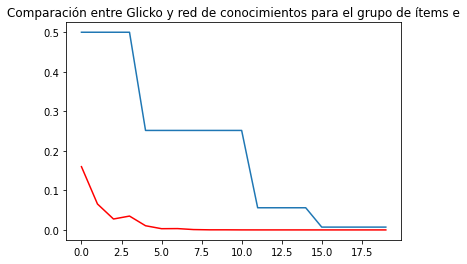

In [142]:
plt.plot(df.index,df[f'e-Glicko'])
plt.plot(df.index,df[f'e-NK'],color="red")
plt.title("Comparación entre Glicko y red de conocimientos para el grupo de ítems e")
plt.show()